# Практическое задание

## Вычитание фона

### О задании

В данном задании вам предлагается самостоятельно реализовать алгоритм вычитания фона ViBe. Протестировать этот алгорит на датасете ChangeDetection 2014 года, а также сравнить качество его работы с алгоритмом, основанным на смеси гауссиан. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. Необходимо установить следующие пакеты: `numpy`, `skimage`, `opencv`. 

In [ ]:
# !pip install numpy scikit-image opencv-python

##  Часть 1

В этой части задания вам предстоит реализовать алгоритм вычитания фона *ViBe* и протестировать его качество работы на датасете *Change Detection 2014*.


**1. (3 балла)**

Прочитайте статью, выданную вам совместно с ноутбуком, описывающую алгоритм *ViBe* и реализуйте следующие его ключевые особенности: 
1. *Цветовая модель пикселей.* Для каждого пикселя хранится набор $\{p_1, ..., p_N\}$ - значений цвета данного пикселя в предыдущие моменты времени. 
2. *Классификация пикселей.* Для каждого нового кадра пиксель считается пикселем фона, если среди значений  $\{p_1, ..., p_N\}$ его цветовой модели содержится не менее K значений, расстояние до которых меньше радиуса R по евклидовой метрике.
3. *Обновления цветовой модели.* Если пиксель был классифицирован как пиксель фона, его цветовая модель обновляется следущий образом: случайно выбранная точка цветовой модели данного пикселя заменяется на новое значения. 
4. *Модель инициализации.* Иницилизируйте цветовую модель для каждого пикселя значением цвета пикселя на первом кадре, а также значениями цвета случайно выбранных соседей(используйте 4'x или 8'ми-связную модель соседства);

Дополните реализуйте следущую модификацию, предложенную этими же авторами позднее:
* "Random time subsampling". Во многих практических ситуациях нет необходимости обновлять фоновую модель каждого пикселя для каждого нового кадра. Если сделать фоновое обновление менее частым, мы искусственно продлеваем средний срок службы фоновых образцов и таким образом боремся со случайными движениями возникающими в кадре. "Random time subsampling" заключается в том что бы не обновлять фоновую модель для каждого пикселя после каждого кадра. А для каждому пикселю сопоставить случаюную величину, которая будет отвечать за то, чтобы обновлять модель данного пикселя или нет, так чтобы обновление произодило в среднем раз в `subsampling_time` кадров (т.е обновлять фоновую модель каждого пикселя с вероятностью `1 / subsampling_time`).

*Замечание*:

Для реализации модели Vibe используйте предоставленный шаблон. Реализация алгоритма на питоне будет работать медленно, поэтому старайтесь выполнять как можно больше вычислений матрично.

In [1]:
import os
from IPython import display

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm

In [2]:
class Vibe:
    def __init__(self, sample_amount, radius, K, subsampling_time):
        """
        'Visual Background Extractor' algorithm of background subtraction

        :param sample_amount: number of samples per pixel
        :param radius: radius of the sphere
        :param K: number of close samples for being part of background
        :param subsampling_time: amount of random subsampling
        """

        self.sample_amount = sample_amount
        self.radius = radius
        self.K = K
        self.subsampling_time = subsampling_time
        self.samples = None


    def initialize(self, image):
        """
        Initialize the model with frame of video sequence.

        :param image: initializining frame
        """
        self.samples = np.zeros((*image.shape, self.sample_amount), dtype=np.uint8)
        idx = np.random.randint(-1, 1, size=(*self.samples.shape, 2))
        idx[0] = np.maximum(0, idx[0])
        idx[:, 0] = np.maximum(0, idx[:, 0])
        idx[-1] = np.minimum(0, idx[-1])
        idx[:, -1] = np.minimum(0, idx[:, -1])
        for i in range(self.samples.shape[0]):
            for j in range(self.samples.shape[1]):
                for k in range(self.samples.shape[2]):
                    for l in range(self.samples.shape[3]):
                        self.samples[i, j, k, l] = image[i, j, k]
    

    def apply(self, image):
        """
        Apply background subtraction algorithm to the next image,
        update internal parameters and return foreground mask.
        If model is not yet initialized, model must be initialized with this image.

        :param image: next image in video sequence
        :return: foreground mask
        """
        image = image.astype(np.float64)
        if type(self.samples) == type(None):
            self.initialize(image)
            return np.zeros((image.shape[0], image.shape[1]))
        else:
            check = np.count_nonzero(np.sum(((self.samples - np.reshape(image, (*image.shape, 1))) ** 2), axis=2) < self.radius ** 2, axis=2) >= self.K
            p = np.logical_and((np.random.rand(*check.shape) < (1. / self.subsampling_time)), check)
            num = np.random.randint(0, self.sample_amount, size=p.shape)
            for i in range(check.shape[0]):
                for j in range(check.shape[1]):
                    if p[i, j]:
                        self.samples[i, j, :, num[i, j]] = image[i, j]
            return np.logical_not(check)
            

**2. (1 балл)**

Посмотрите как работает алгоритм на различных фрагментах видео из категориии Baseline датасета ChangeDetection2014, выданного вам совместно с ноутбуком. Поиграйтесь с параметрами и сделайте выводы.

Для визуализации покадрового применения алгоритма можете использовать код, написанный ниже.

*Замечание: *  
Полную версию датасета можно найти [здесь](http://changedetection.net/)

In [3]:
def image_generator(dirpath, first_frame=1, last_frame=None):
    """
    Generator of (frame_number, image, groundtruth) tuples.

    :param dirpath: Path to dir contained 'input' and 'groundtruth' subdirs
    :param first_frame: int, optional. Frame number from which the generator starts (inclusive)
    :param last_frame: int, optional. If provide, frame number  where the generator stops (inclusive)
    :return: (frame_number, image, groundtruth) tuples
    """

    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'

    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        
        
def apply_bg_substractor(bg_substractor, image_generator):
    """
    Apply background substruction algorithm for each frame of image_generator consistently

    :return: generator of (frame_number, frame, bg_substructor_mask, groundtruth) tuples
    """

    for numb, frame, gt in image_generator:
        mask = bg_substractor.apply(frame)
        yield numb, frame, mask, gt


def plot_bg_result(frame_number, frame, mask, gt, axs=None):
    """
    Draw frame, foreground mask, groundtruth mask images on axes.
    """
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(frame)
    axs[0].set_title("Frame: {}".format(frame_number))
    
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("BG result")

    axs[2].imshow(gt, cmap='gray')
    axs[2].set_title("Ground truth")

In [4]:
image_gen = image_generator('dataset/baseline/pedestrians')
bg_substractor = Vibe(20, 30., 2, 2)

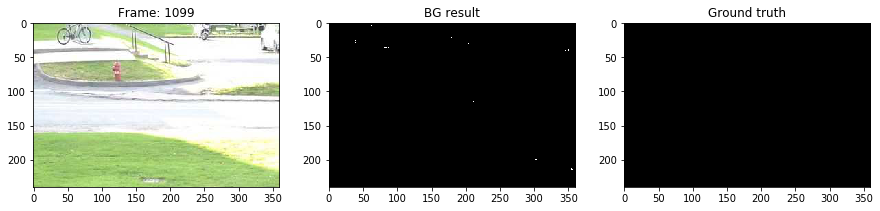

1099it [13:19,  1.21it/s]


In [6]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**3. (1 балл)**

Визуально протестируйте алгоритм на видео из категории Baseline.  Покажите ключевые кадры и проанализируйте результаты.  Сделайте выводы о плюсах и минусах алгоритма. 

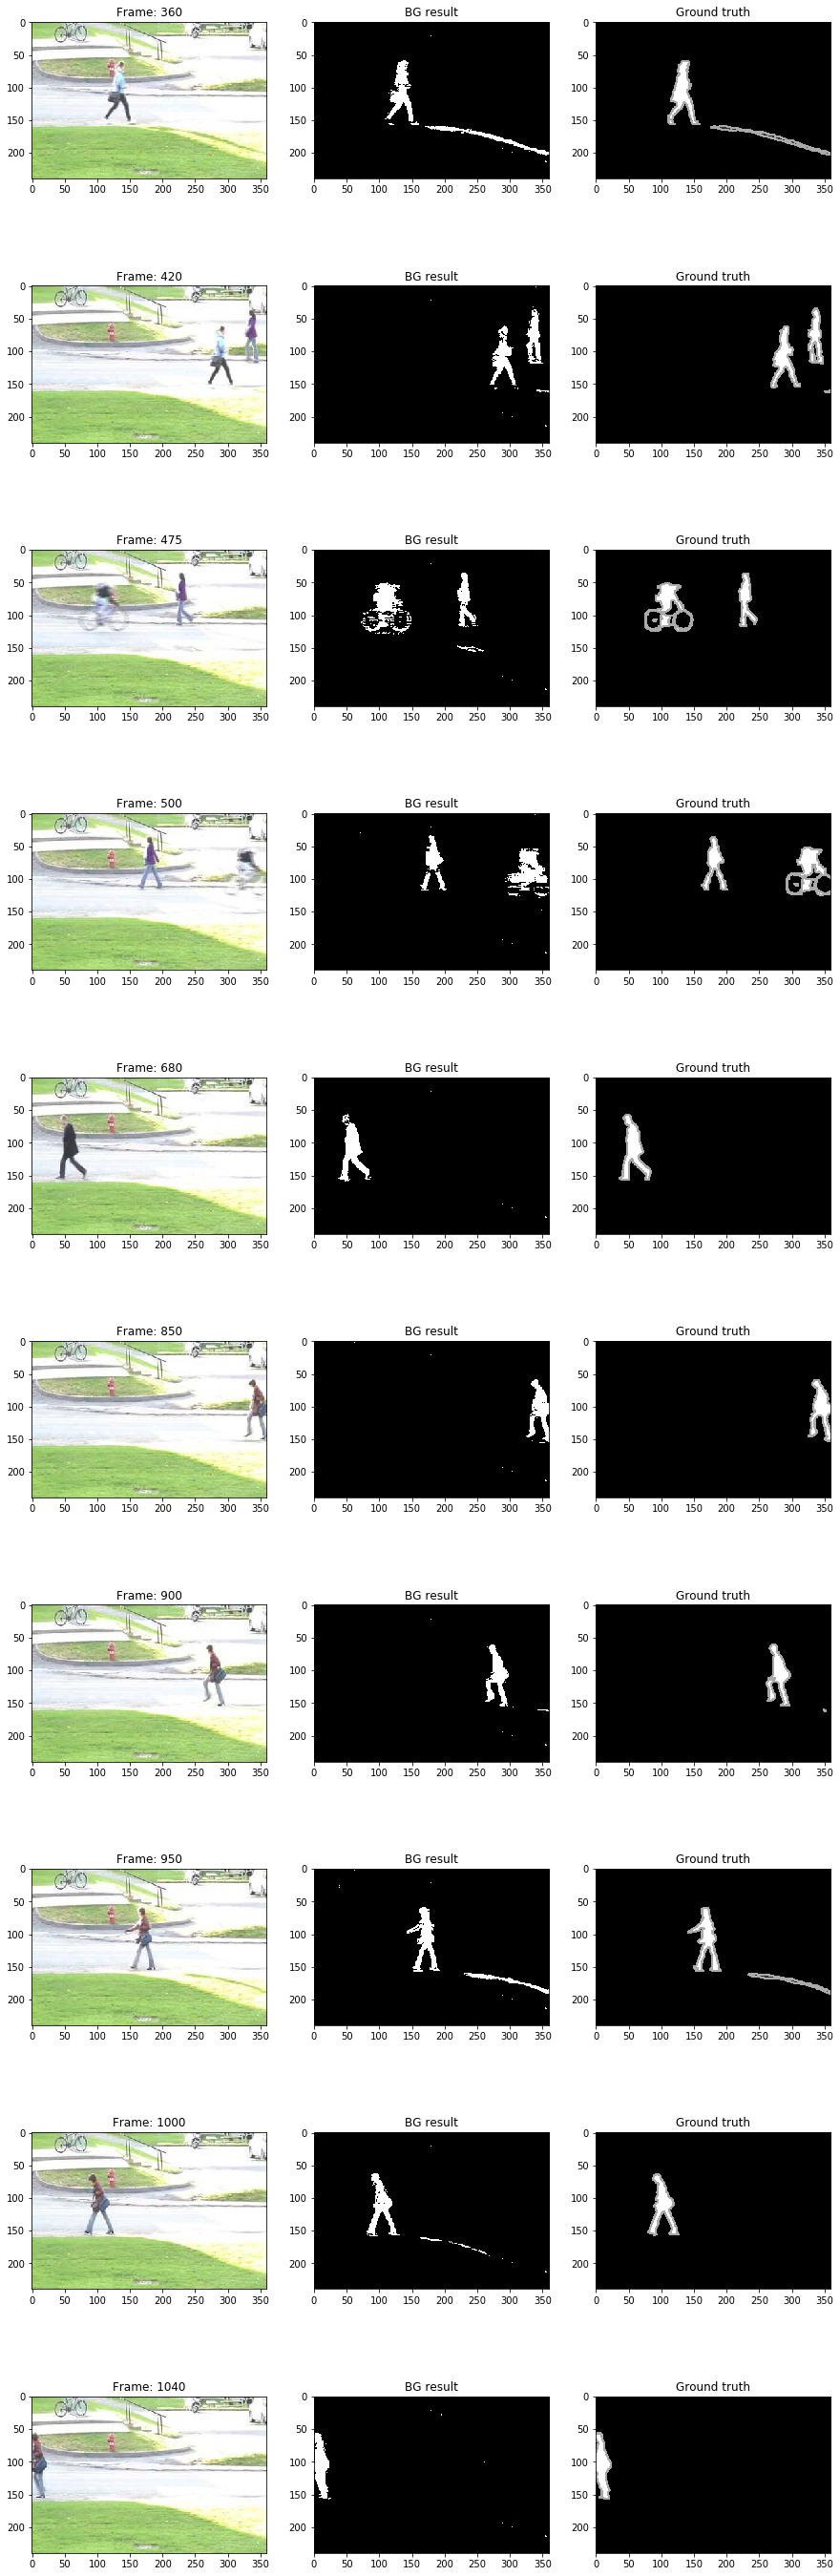

1099it [03:57,  5.14it/s]


In [4]:
image_gen = image_generator('dataset/baseline/pedestrians')
bg_substractor = Vibe(20, 30., 2, 2)

frames = [360, 420, 475, 500, 680, 850, 900, 950, 1000, 1040]
i = 0

_, axs = plt.subplots(len(frames), 3, figsize=(15, 5 * len(frames)))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    if numb in frames:
        for ax in axs[i]:
            ax.cla()
        plot_bg_result(numb, frame, mask, gt, axs[i])
        i += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
plt.close()

**Выводы:**
Достоинство алгоритма заключается в хорошем качестве работы на видео, где присутствуют достаточно (но не слишком, чтобы успела обновиться его цветовая модель) быстро движущиеся объекты, сильно отличающиеся по цвету от фона. Недостатком же является отсутствие обновления модели, если мы отнесли пиксель не к фону. Таким образом, если объект перестаёт двигаться (как тень человека, влившаяся в большую тень), то пиксели все равно будут относиться не к фону.

## Часть 2

В этой части задания вам необходимо реализовать метрики оценки качества вычитания фона, протестировать реализованый вами алгоритм Vibe на категории Baseline датасета ChangeDetection2014.


**4. (0.5 балла)**

Реализуйте следущие метрики:
\begin{equation*}
\begin{array}{l}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F_1{\text -}score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{array}
\end{equation*}

In [4]:
def precision(confusion_matrix):
    """
    Compute the precision

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    
    res = confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[1])
    return res


def recall(confusion_matrix):
    """
    Compute the recall

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    
    res = confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[2])
    return res


def f1_score(confusion_matrix):
    """
    Compute the f1_score

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    pre = precision(confusion_matrix)
    rec = recall(confusion_matrix)
    res = 2. * pre * rec / (pre + rec)
    return res

**5. (2 балла) **

Посчитайте значение метрик качества $precision$, $recall$, $f_1{\text -}score$ для всех видео из категории Baseline. Также посчитайте среднее значение этих метрик по категории. Вам необходимо достичь среднего значения $f_1{\text -}score$ более 0.8 для категории Baseline.

*Замечание 1:*  
$TP$, $FP$, $FN$, $TP$ надо аккумулировать для всего видео, после чего надо вычислить значение метрик для каждого видео по описанным выше формулам и усреднить по всем видео из категории.

*Замечание 2:*  
В разметке встречаются следующие метки:
* 0 : Static
* 50 : Hard shadow
* 85 : Outside region of interest
* 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
* 255 : Motion

При подсчет метрик качества вам необходимо учитывать только метки: 0 и 50 - это пиксели фона, и 255 - это пиксели переднего плана. Пиксели, содержащие метки 85 и 170 надо не учитывать при подсчете метрик качества.

In [6]:
dirpath = 'dataset/baseline/'
results = []
for s in os.listdir(dirpath):
    name = os.path.join(dirpath, s)
    image_gen = image_generator(name)
    bg_substractor = Vibe(20, 30., 2, 2)
    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    n = 0
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
        n += 1
        tp += np.count_nonzero(np.logical_and((gt == 255), mask))
        tn += np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), np.logical_not(mask)))
        fp += np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), mask))
        fn += np.count_nonzero(np.logical_and((gt == 255), np.logical_not(mask)))
    tp /= n
    tn /= n
    fp /= n
    fn /= n
    confusion_matrix = [tn, fp, fn, tp]
    results.append([s, precision(confusion_matrix), recall(confusion_matrix), f1_score(confusion_matrix)])

1700it [04:25,  5.81it/s]
2050it [06:38,  5.27it/s]
1099it [03:37,  5.15it/s]
1200it [16:21,  1.21it/s]


In [8]:
for i in range(len(results)):
    print('Name: %s ; precision: %.3f ; recall: %.3f ; f1_score: %.3f' % (results[i][0], results[i][1], results[i][2], results[i][3]))
average = []
for i in range(len(results)):
    if i == 0:
        for j in range(1, 4):
            average.append(results[i][j])
    else:
        for j in range(3):
            average[j] += results[i][j+1]
for i in range(len(average)):
    average[i] /= len(results)
print('Average: precision: %.3f ; recall: %.3f ; f1_score: %.3f' % (average[0], average[1], average[2]))

Name: highway ; precision: 0.843 ; recall: 0.874 ; f1_score: 0.858
Name: office ; precision: 0.953 ; recall: 0.910 ; f1_score: 0.931
Name: pedestrians ; precision: 0.894 ; recall: 0.966 ; f1_score: 0.929
Name: PETS2006 ; precision: 0.823 ; recall: 0.789 ; f1_score: 0.806
Average: precision: 0.878 ; recall: 0.885 ; f1_score: 0.881


## Часть 3

В этой части задания вам предстоит протестировать алгоритм, основанный на смеси гауссиан из библиотеки `opencv`. Сравнить работу этого алгоритма с алгоритмом Vibe, а также посмотреть как ведут себя алгоритмы при добавление шума различной степени на изображение.


**6. (0.5 балл)**

Посмотрите как ведет себя алгоритм `MOG2` из библиотеки `opencv`. Аналогично как из с алгоритмом Vibe провизиализируйте покадровую работу алгоритма на какой-нибудь части видео и визуально оцените качество работы взависимости от параметров `history` и `varThreshhold`, параметр `detectShadows` установите равным False. Какие выводы вы можете сделать?

In [5]:
from cv2 import createBackgroundSubtractorMOG2

mog2 = createBackgroundSubtractorMOG2(history=20, varThreshold=30, detectShadows=False)
image_gen = image_generator('dataset/baseline/pedestrians')

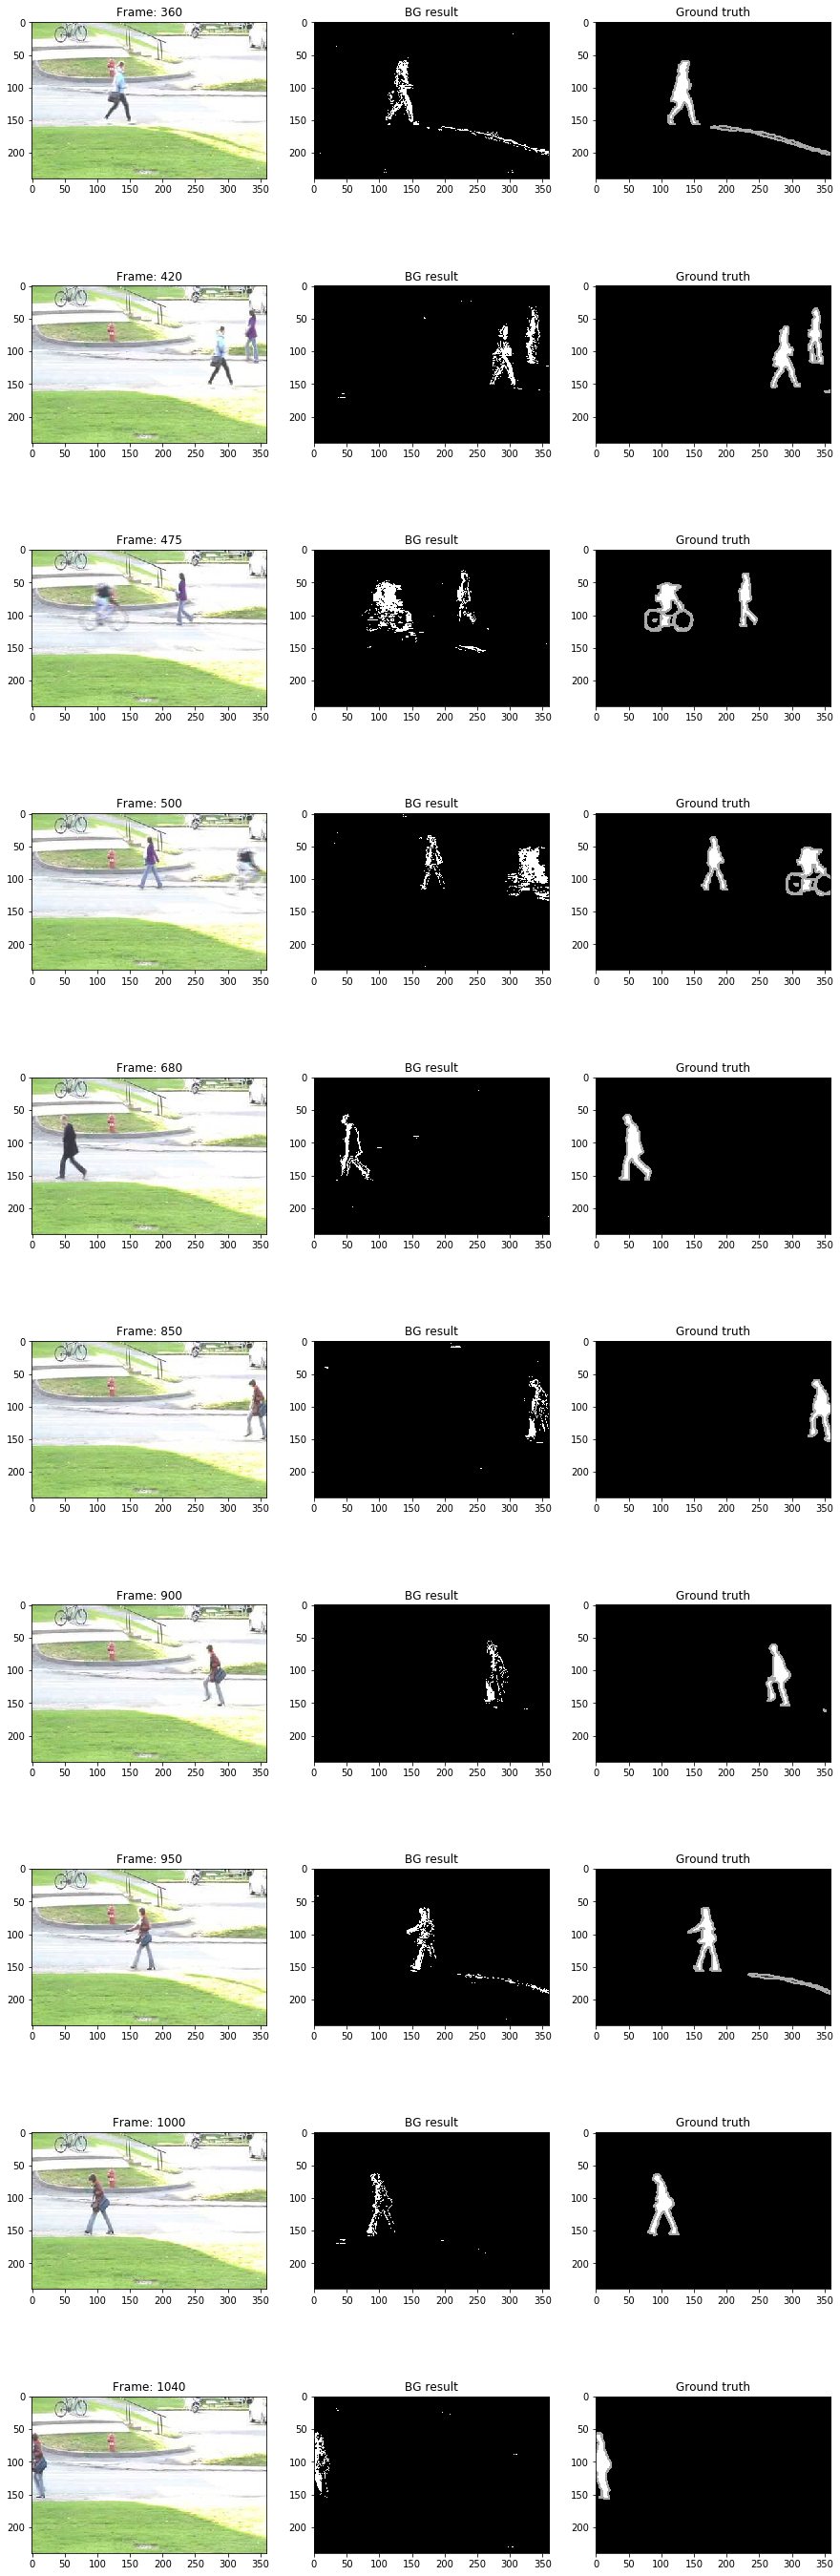

1099it [00:21, 50.10it/s]


In [7]:
frames = [360, 420, 475, 500, 680, 850, 900, 950, 1000, 1040]
i = 0

_, axs = plt.subplots(len(frames), 3, figsize=(15, 5 * len(frames)))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    if numb in frames:
        for ax in axs[i]:
            ax.cla()
        plot_bg_result(numb, frame, mask, gt, axs[i])
        i += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
plt.close()

**Выводы:**

Внутренние части движущихся объектов, однородные по цвету, отмечаются как фон.

**7. (1 балл)**

Выберите один кадр из набора ключевых кадров, отобранных ключевых кадрах в пункте 3 и добавляйте к
нему попиксельно независимый гауссовский шум. Проанализируйте результаты вычитания фона обоими методами для шума различной интенсивности. Подберите параметры алгоритмов для работы с зашумленными изображениями.  Визуализируйте результаты работы обоих алгоритмов а также вычислите $f_1{\text -}score$ для всех экспрериментов. Сделайте выводы.

*Замечание 1:*  
Сравнение проводите честно, подавайте в алгоритм одинаковое кол-во впереди идущих кадров, необходимых для настройки внутренних параметров алгоритма.

*Замечание 2:*  

Ко всем кадрам, подаваемым в модель, необходимо также добавлять гауссовский шум.

In [6]:
frame_num = 475

def noise_generator(sigma):
    image_gen = image_generator('dataset/baseline/pedestrians')
    while True:
        n, f, g = next(image_gen)
        f = f.astype(np.int64)
        f += np.random.normal(scale=sigma, size=(f.shape)).astype(np.int64)
        yield n, (np.minimum(np.maximum(f, 0), 255)).astype(np.uint8), g

def get_confusion_matrix(mask, gt):
    tp = np.count_nonzero(np.logical_and((gt == 255), mask))
    tn = np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), np.logical_not(mask)))
    fp = np.count_nonzero(np.logical_and(np.logical_or(gt == 0, gt == 50), mask))
    fn = np.count_nonzero(np.logical_and((gt == 255), np.logical_not(mask)))
    confusion_matrix = [tn, fp, fn, tp]
    return confusion_matrix
        
def get_mog2_result(sigma):
    """
    Apply MOG2 algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    mog2 = createBackgroundSubtractorMOG2(history=20, varThreshold=30, detectShadows=False)
    gen = noise_generator(sigma)
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, gen)):
        if numb == frame_num:
            return frame, mask, gt
    
def get_vibe_result(sigma):
    """
    Apply ViBe algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    bg_substractor = Vibe(20, 30., 2, 2)
    gen = noise_generator(sigma)
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, gen)):
        if numb == frame_num:
            return frame, mask, gt
    














0it [00:00, ?it/s]












1it [00:03,  3.19s/it]












2it [00:03,  2.30s/it]












3it [00:03,  1.68s/it]












4it [00:03,  1.24s/it]












5it [00:04,  1.07it/s]












6it [00:04,  1.38it/s]












7it [00:04,  1.75it/s]












8it [00:04,  2.20it/s]












9it [00:04,  2.61it/s]












10it [00:05,  3.00it/s]












11it [00:05,  3.33it/s]












12it [00:05,  3.64it/s]












13it [00:05,  3.93it/s]












14it [00:06,  4.09it/s]












15it [00:06,  4.06it/s]












16it [00:06,  3.94it/s]












17it [00:06,  3.90it/s]












18it [00:07,  4.07it/s]












19it [00:07,  4.15it/s]












20it [00:07,  4.25it/s]












21it [00:07,  4.50it/s]












22it [00:07,  4.33it/s]












23it [00:08,  4.22it/s]












24it [00:08,  4.20it/s]












25it [00:08,  4.29it/s]












26it [00:08,  4.30it/s]












27it [00:09,  4.36it/s]







445it [01:40,  4.63it/s]












446it [01:40,  4.73it/s]












447it [01:40,  4.87it/s]












448it [01:41,  4.90it/s]












449it [01:41,  4.65it/s]












450it [01:41,  4.88it/s]












451it [01:41,  4.84it/s]












452it [01:41,  4.81it/s]












453it [01:42,  4.93it/s]












454it [01:42,  4.94it/s]












455it [01:42,  4.95it/s]












456it [01:42,  4.96it/s]












457it [01:42,  4.89it/s]












458it [01:43,  4.86it/s]












459it [01:43,  4.88it/s]












460it [01:43,  4.83it/s]












461it [01:43,  4.75it/s]












462it [01:43,  4.73it/s]












463it [01:44,  4.73it/s]












464it [01:44,  4.54it/s]












465it [01:44,  4.73it/s]












466it [01:44,  4.82it/s]












467it [01:45,  4.85it/s]












468it [01:45,  4.89it/s]












469it [01:45,  4.99it/s]












470it [01:45,  4.91it/s]












471it [01:45,  5.00it/s]












4

297it [01:13,  4.37it/s]














298it [01:14,  4.33it/s]














299it [01:14,  4.39it/s]














300it [01:14,  4.38it/s]














301it [01:14,  4.43it/s]














302it [01:15,  4.27it/s]














303it [01:15,  4.43it/s]














304it [01:15,  4.46it/s]














305it [01:15,  4.61it/s]














306it [01:15,  4.46it/s]














307it [01:16,  4.48it/s]














308it [01:16,  4.45it/s]














309it [01:16,  4.40it/s]














310it [01:16,  4.41it/s]














311it [01:17,  4.44it/s]














312it [01:17,  4.36it/s]














313it [01:17,  4.33it/s]














314it [01:17,  4.25it/s]














315it [01:17,  4.37it/s]














316it [01:18,  4.38it/s]














317it [01:18,  4.53it/s]














318it [01:18,  4.49it/s]














319it [01:18,  4.64it/s]














320it [01:19,  4.58it/s]














321it [01:19,  4.60it/s]














322it [01:19,  4.43it/s]


154it [00:03, 41.43it/s]















159it [00:03, 42.03it/s]















164it [00:03, 40.80it/s]















169it [00:04, 41.06it/s]















174it [00:04, 41.82it/s]















179it [00:04, 42.24it/s]















184it [00:04, 42.05it/s]















189it [00:04, 41.54it/s]















194it [00:04, 41.57it/s]















199it [00:04, 40.96it/s]















204it [00:04, 41.19it/s]















209it [00:05, 41.95it/s]















214it [00:05, 42.26it/s]















219it [00:05, 42.10it/s]















224it [00:05, 41.98it/s]















229it [00:05, 40.86it/s]















234it [00:05, 40.73it/s]















239it [00:05, 41.39it/s]















244it [00:05, 41.47it/s]















249it [00:06, 40.51it/s]















254it [00:06, 40.61it/s]















259it [00:06, 41.15it/s]















264it [00:06, 41.31it/s]















269it [00:06, 41.43it/s]















274it [00:06, 41.49it/s]

















337it [01:21,  4.19it/s]
















338it [01:21,  4.10it/s]
















339it [01:22,  3.94it/s]
















340it [01:22,  3.85it/s]
















341it [01:22,  3.86it/s]
















342it [01:22,  3.91it/s]
















343it [01:23,  3.91it/s]
















344it [01:23,  3.87it/s]
















345it [01:23,  3.87it/s]
















346it [01:23,  3.84it/s]
















347it [01:24,  3.85it/s]
















348it [01:24,  3.90it/s]
















349it [01:24,  3.96it/s]
















350it [01:24,  4.01it/s]
















351it [01:25,  3.99it/s]
















352it [01:25,  3.94it/s]
















353it [01:25,  3.80it/s]
















354it [01:25,  3.78it/s]
















355it [01:26,  3.72it/s]
















356it [01:26,  3.79it/s]
















357it [01:26,  3.87it/s]
















358it [01:26,  3.85it/s]
















359it [01:27,  3.80it/s]
















360it [01:27,  3.75it/s]
















361it [01:27,  3

152it [00:34,  4.61it/s]


















153it [00:34,  4.62it/s]


















154it [00:34,  4.59it/s]


















155it [00:34,  4.69it/s]


















156it [00:35,  4.67it/s]


















157it [00:35,  4.63it/s]


















158it [00:35,  4.55it/s]


















159it [00:35,  4.51it/s]


















160it [00:35,  4.65it/s]


















161it [00:36,  4.58it/s]


















162it [00:36,  4.61it/s]


















163it [00:36,  4.68it/s]


















164it [00:36,  4.62it/s]


















165it [00:37,  4.69it/s]


















166it [00:37,  4.78it/s]


















167it [00:37,  4.89it/s]


















168it [00:37,  4.80it/s]


















169it [00:37,  4.70it/s]


















170it [00:38,  4.88it/s]


















171it [00:38,  4.82it/s]


















172it [00:38,  4.76it/s]


















173it [00:38,  4.51it/s]


















174it [00:38,  4.39it/s]


















175it [00:3

228it [00:06, 36.34it/s]



















232it [00:06, 36.10it/s]



















236it [00:06, 36.60it/s]



















240it [00:06, 36.06it/s]



















244it [00:06, 36.46it/s]



















248it [00:06, 35.46it/s]



















252it [00:07, 35.36it/s]



















256it [00:07, 35.08it/s]



















260it [00:07, 35.47it/s]



















264it [00:07, 35.31it/s]



















268it [00:07, 36.05it/s]



















272it [00:07, 35.17it/s]



















276it [00:07, 34.59it/s]



















280it [00:07, 35.06it/s]



















284it [00:08, 34.86it/s]



















288it [00:08, 35.28it/s]



















292it [00:08, 35.60it/s]



















296it [00:08, 35.86it/s]



















300it [00:08, 35.03it/s]



















304it [00:08, 34.53it/s]



















308it [00:08, 33.85it/s]



















312it [00:08, 33.66it/s]



















316it [00:08, 33.55it/s]









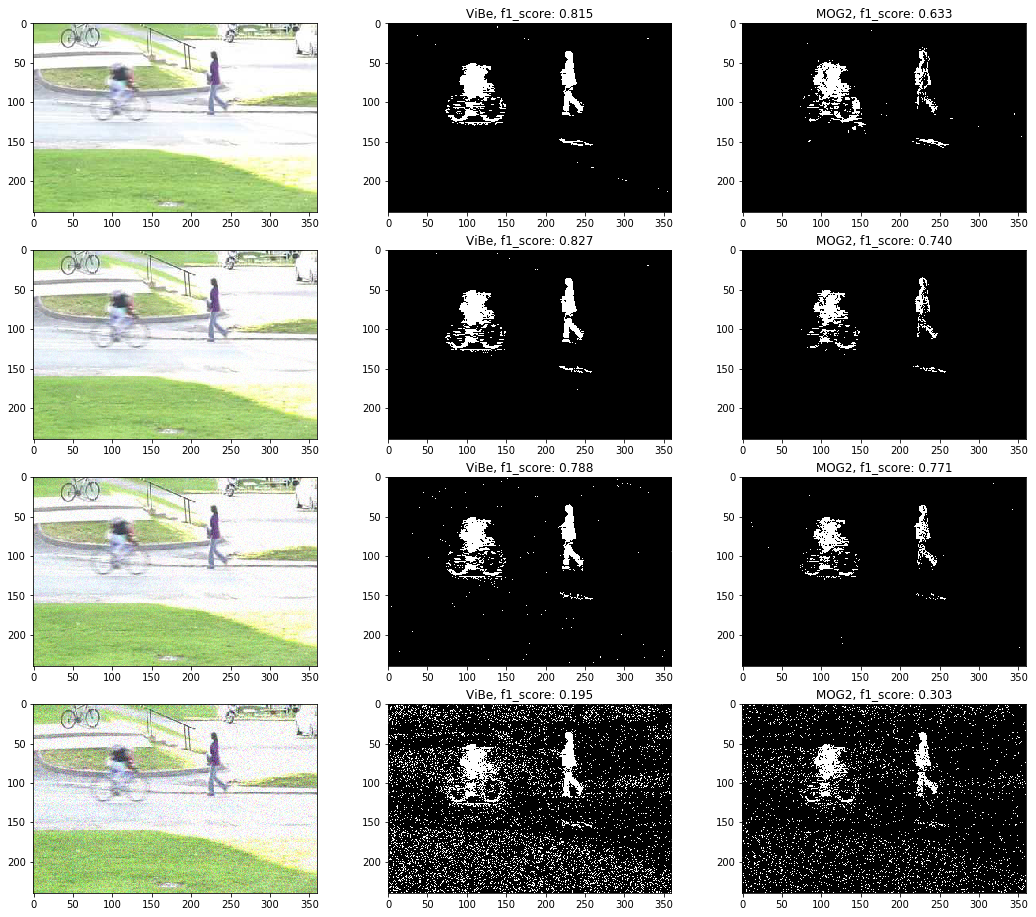





















472it [00:30, 34.97it/s]

In [16]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    frame, mog2_mask, gt = get_mog2_result(sigma)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("ViBe, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(mog2_mask, cmap='gray')
    axs[i][2].set_title("MOG2, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(mog2_mask, gt))))

**Выводы:**

При очень сильном зашумлении алгоритм ViBe сильнее теряет в качетсве работы, чем алгоритм на смеси гауссиан. В остальных же случаях ViBe превосходит MOG2.

**8. (1 балл)**

Предложите метод борьбы с шумом на карте "фон-объект" и проанализируйте его эффективность. Сравнивайте результаты по какой-нибудь метрики качества, например $f_1{\text -}score$.

*Замечание:*

Можно использовать любые функции обработки изображений из библиотек `opencv` и `skimage`.

In [7]:
from skimage.filters import median
def post_process(mask):
    """
    Postprocessing foreground mask
    """
    return median(mask)

474it [01:46,  4.58it/s]
0it [00:00, ?it/s]
1it [00:03,  3.18s/it]
2it [00:03,  2.30s/it]
3it [00:03,  1.67s/it]
4it [00:03,  1.24s/it]
5it [00:04,  1.07it/s]
6it [00:04,  1.39it/s]
7it [00:04,  1.75it/s]
8it [00:04,  2.10it/s]
9it [00:05,  2.47it/s]
10it [00:05,  2.79it/s]
11it [00:05,  3.19it/s]
12it [00:05,  3.53it/s]
13it [00:05,  3.75it/s]
14it [00:06,  3.91it/s]
15it [00:06,  4.08it/s]
16it [00:06,  4.16it/s]
17it [00:06,  4.21it/s]
18it [00:07,  4.35it/s]
19it [00:07,  4.33it/s]
20it [00:07,  4.41it/s]
21it [00:07,  4.33it/s]
22it [00:07,  4.35it/s]
23it [00:08,  4.48it/s]
24it [00:08,  4.43it/s]
25it [00:08,  4.35it/s]
26it [00:08,  4.28it/s]
27it [00:09,  4.26it/s]
28it [00:09,  4.34it/s]
29it [00:09,  4.32it/s]
30it [00:09,  4.35it/s]
31it [00:10,  4.19it/s]
32it [00:10,  4.23it/s]
33it [00:10,  4.09it/s]
34it [00:10,  4.13it/s]
35it [00:11,  4.29it/s]
36it [00:11,  4.19it/s]
37it [00:11,  4.14it/s]
38it [00:11,  4.35it/s]
39it [00:11,  4.23it/s]
40it [00:12,  4.37it/s]
41it 

331it [01:15,  4.30it/s]
332it [01:15,  4.37it/s]
333it [01:15,  4.37it/s]
334it [01:15,  4.48it/s]
335it [01:15,  4.55it/s]
336it [01:16,  4.59it/s]
337it [01:16,  4.58it/s]
338it [01:16,  4.57it/s]
339it [01:16,  4.44it/s]
340it [01:17,  4.47it/s]
341it [01:17,  4.44it/s]
342it [01:17,  4.43it/s]
343it [01:17,  4.38it/s]
344it [01:17,  4.39it/s]
345it [01:18,  4.32it/s]
346it [01:18,  4.32it/s]
347it [01:18,  4.46it/s]
348it [01:18,  4.42it/s]
349it [01:19,  4.44it/s]
350it [01:19,  4.37it/s]
351it [01:19,  4.41it/s]
352it [01:19,  4.29it/s]
353it [01:19,  4.42it/s]
354it [01:20,  4.38it/s]
355it [01:20,  4.45it/s]
356it [01:20,  4.48it/s]
357it [01:20,  4.47it/s]
358it [01:21,  4.52it/s]
359it [01:21,  4.44it/s]
360it [01:21,  4.50it/s]
361it [01:21,  4.49it/s]
362it [01:21,  4.53it/s]
363it [01:22,  4.53it/s]
364it [01:22,  4.42it/s]
365it [01:22,  4.40it/s]
366it [01:22,  4.44it/s]
367it [01:23,  4.33it/s]
368it [01:23,  4.45it/s]
369it [01:23,  4.42it/s]
370it [01:23,  4.31it/s]


181it [00:43,  4.36it/s]

182it [00:44,  4.24it/s]

183it [00:44,  4.23it/s]

184it [00:44,  4.29it/s]

185it [00:44,  4.31it/s]

186it [00:45,  4.28it/s]

187it [00:45,  4.43it/s]

188it [00:45,  4.49it/s]

189it [00:45,  4.39it/s]

190it [00:45,  4.40it/s]

191it [00:46,  4.36it/s]

192it [00:46,  4.38it/s]

193it [00:46,  4.31it/s]

194it [00:46,  4.36it/s]

195it [00:47,  4.35it/s]

196it [00:47,  4.30it/s]

197it [00:47,  4.39it/s]

198it [00:47,  4.32it/s]

199it [00:47,  4.45it/s]

200it [00:48,  4.33it/s]

201it [00:48,  4.48it/s]

202it [00:48,  4.44it/s]

203it [00:48,  4.41it/s]

204it [00:49,  4.33it/s]

205it [00:49,  4.34it/s]

206it [00:49,  4.34it/s]

207it [00:49,  4.34it/s]

208it [00:50,  4.35it/s]

209it [00:50,  4.40it/s]

210it [00:50,  4.30it/s]

211it [00:50,  4.46it/s]

212it [00:50,  4.40it/s]

213it [00:51,  4.29it/s]

214it [00:51,  4.31it/s]

215it [00:51,  4.32it/s]

216it [00:51,  4.44it/s]

217it [00:52,  4.45it/s]

218it [00:52,  4.50it/s]

219it [00:52

21it [00:06,  5.17it/s]


22it [00:07,  5.12it/s]


23it [00:07,  5.35it/s]


24it [00:07,  5.33it/s]


25it [00:07,  5.31it/s]


26it [00:07,  5.21it/s]


27it [00:08,  5.23it/s]


28it [00:08,  5.32it/s]


29it [00:08,  5.22it/s]


30it [00:08,  5.15it/s]


31it [00:08,  5.35it/s]


32it [00:09,  5.24it/s]


33it [00:09,  5.09it/s]


34it [00:09,  5.22it/s]


35it [00:09,  5.15it/s]


36it [00:09,  5.03it/s]


37it [00:10,  4.94it/s]


38it [00:10,  5.04it/s]


39it [00:10,  5.10it/s]


40it [00:10,  5.04it/s]


41it [00:10,  4.98it/s]


42it [00:11,  5.03it/s]


43it [00:11,  5.03it/s]


44it [00:11,  4.97it/s]


45it [00:11,  5.13it/s]


46it [00:11,  5.09it/s]


47it [00:12,  4.96it/s]


48it [00:12,  5.00it/s]


49it [00:12,  4.93it/s]


50it [00:12,  4.95it/s]


51it [00:12,  4.80it/s]


52it [00:13,  4.86it/s]


53it [00:13,  4.99it/s]


54it [00:13,  5.00it/s]


55it [00:13,  4.92it/s]


56it [00:13,  4.88it/s]


57it [00:14,  4.95it/s]


58it [00:14,  4.85it/s]


59it [00:14,

327it [01:12,  4.61it/s]


328it [01:12,  4.57it/s]


329it [01:12,  4.57it/s]


330it [01:12,  4.69it/s]


331it [01:12,  4.65it/s]


332it [01:13,  4.74it/s]


333it [01:13,  4.64it/s]


334it [01:13,  4.66it/s]


335it [01:13,  4.68it/s]


336it [01:13,  4.60it/s]


337it [01:14,  4.58it/s]


338it [01:14,  4.54it/s]


339it [01:14,  4.61it/s]


340it [01:14,  4.59it/s]


341it [01:15,  4.54it/s]


342it [01:15,  4.60it/s]


343it [01:15,  4.63it/s]


344it [01:15,  4.69it/s]


345it [01:15,  4.62it/s]


346it [01:16,  4.66it/s]


347it [01:16,  4.59it/s]


348it [01:16,  4.39it/s]


349it [01:16,  4.44it/s]


350it [01:17,  4.41it/s]


351it [01:17,  4.51it/s]


352it [01:17,  4.62it/s]


353it [01:17,  4.62it/s]


354it [01:17,  4.64it/s]


355it [01:18,  4.68it/s]


356it [01:18,  4.73it/s]


357it [01:18,  4.61it/s]


358it [01:18,  4.58it/s]


359it [01:19,  4.57it/s]


360it [01:19,  4.63it/s]


361it [01:19,  4.54it/s]


362it [01:19,  4.52it/s]


363it [01:19,  4.66it/s]


3

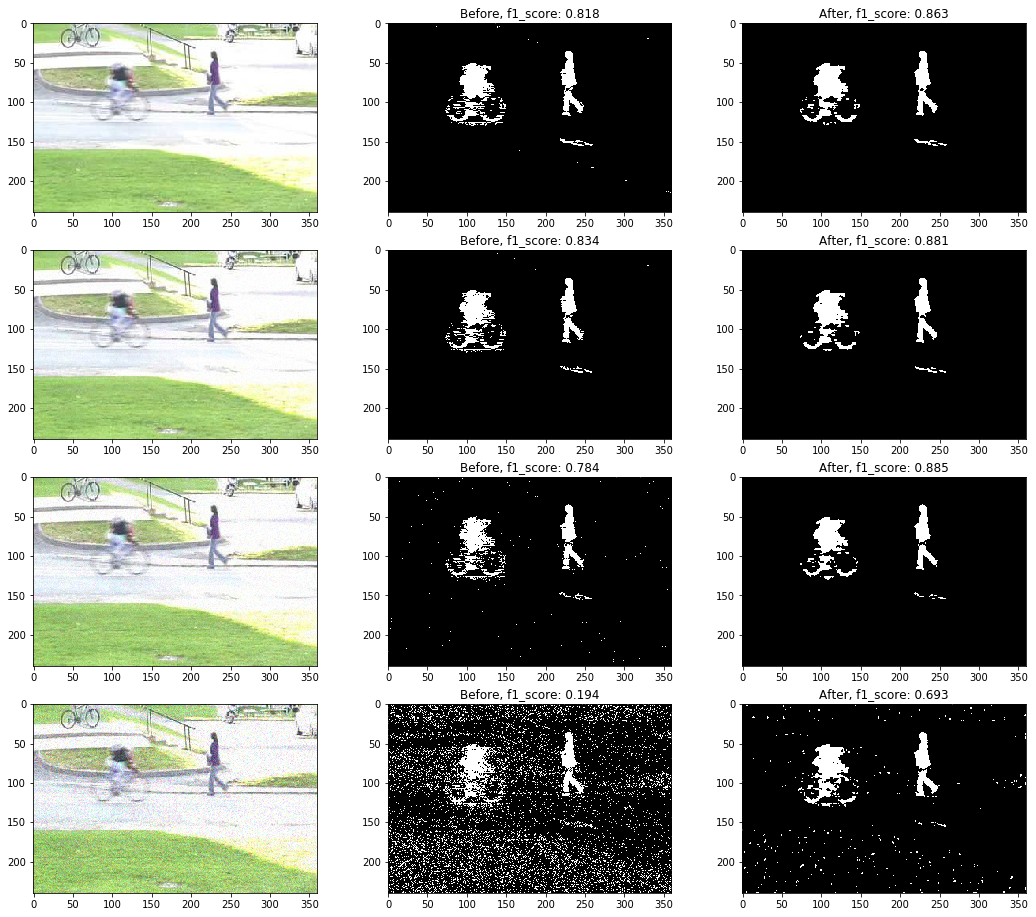

In [8]:
sigmas = [0, 5, 10, 20]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    process_mask = post_process(vibe_mask)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("Before, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(vibe_mask, gt))))
    
    axs[i][2].imshow(process_mask, cmap='gray')
    axs[i][2].set_title("After, f1_score: {:.3f}".format(f1_score(get_confusion_matrix(process_mask, gt))))

**Выводы:**

Использование медианной пост-фильтрации сильно улучшает качество на сильно зашумленном гауссовским шумом изображении.